03 - Accessing and Querying the Detect Database
=======

This notebook demonstrates how to open the HDF5 container for the HETDEX line detections database. This database is a catalog of line emission detections and their associated 1D, aperture summed, psf-weighted spectra. There are three tables contained within this HDF5 file: 

1. Detections - this is the main database of line detection sources. It provides the position and central wavelength of each detection and corresponding line fluxes. A source detection corresponds to an emission line so it is possible to have multiple line detections at different wavelengths for a single source. There can also be multiple observations of the same line if it has been observed in multiple shots or if it is associated with a large source. 

2. Fibers - for each source detection, this table lists information about each fiber used to extract the flux measurment and weighted spectrum. This allows a user to return to the processed data products (ie. the shot HDF5 files) to investigate the source further.

3. Spectra - for each source, this table contains arrays of wavelength and 1D flux-weighted aperture summed spectral data and corresponding errors. Non-calibrated spectra is also provided in counts


In [1]:
%matplotlib inline
import sys
import os
import os.path
import subprocess
import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table, Column

from hetdex_api import config

In [2]:
## open the detect file using pytables 
fileh = tb.open_file(config.detecth5)

## to open and close the continuum source file using pytables
filecont = tb.open_file(config.contsourceh5)
filecont.close()

In [3]:
# to access the main detetion table:
detects = fileh.root.Detections 

# to see a list of columns in the main detection table
detects.cols

/Detections.cols (Cols), 28 columns
  detectid (Column(690868,), int64)
  detectname (Column(690868,), |S40)
  inputid (Column(690868,), |S32)
  date (Column(690868,), int32)
  obsid (Column(690868,), int32)
  ra (Column(690868,), float32)
  dec (Column(690868,), float32)
  wave (Column(690868,), float32)
  wave_err (Column(690868,), float32)
  flux (Column(690868,), float32)
  flux_err (Column(690868,), float32)
  linewidth (Column(690868,), float32)
  linewidth_err (Column(690868,), float32)
  continuum (Column(690868,), float32)
  continuum_err (Column(690868,), float32)
  sn (Column(690868,), float32)
  sn_err (Column(690868,), float32)
  chi2 (Column(690868,), float32)
  chi2_err (Column(690868,), float32)
  multiframe (Column(690868,), |S20)
  fibnum (Column(690868,), int32)
  x_raw (Column(690868,), int32)
  y_raw (Column(690868,), int32)
  amp (Column(690868,), |S2)
  ifuid (Column(690868,), |S3)
  ifuslot (Column(690868,), |S3)
  shotid (Column(690868,), int64)
  specid (Colum

The entire table or an entire column can be pulled into local memory into an array using [:] or .read(), or you can slice as you wish, but likely you want to query to figure out which data you are interested in.


In [4]:
ra = detects.cols.ra[:]

If you don't need the entire table its better to subselect a part of the table. For example, read only the table where all detections between 4200AA and 4250AA


In [5]:
detect_table = detects.read_where("(wave > 4200) & (wave < 4250)")

This reads the database into a numpy table which you can then directly work with as usual. For example, read in the detectid, or the input detect name:

In [6]:
detect_table['detectid']

array([1000000067, 1000000125, 1000000159, ..., 1000690754, 1000690788,
       1000690792])

In [7]:
detect_table['inputid']

array(['20170103v002_1291', '20170103v002_1518', '20170103v002_1646', ...,
       '20181114v014_478', '20190201v015_8203', '20190204v013_5017'],
      dtype='|S32')

Let's work through a quick example. Say I want to find and save the 1D spectra for all objects with SN>30 and a central wavelength within 4000-4200 AA in COSMOS (at RA=150deg, DEC=2.2deg) I could do the following query:

In [8]:
detect_table = detects.read_where("(sqrt((ra-150)**2 + (dec-2.2)**2) < 1) & (sn>30) & (wave > 4000) & (wave < 4200)")

To find out how many objects are in the table just use np.size:

In [9]:
np.size(detect_table)

21

To store this subset into an output table, figure out columns you want to export and store into another table then write to a file.

In [10]:
outputtable = detect_table[['detectid','inputid','flux','flux_err','sn','sn_err','wave','wave_err']]
ascii.write(outputtable,'output.dat', overwrite=True)

The 1D flux-weighted spectra are stored in the Spectra table:

In [10]:
spectra = fileh.root.Spectra
spectra.cols

/Spectra.cols (Cols), 8 columns
  detectid (Column(690797,), int64)
  wave1d (Column(690797, 1036), ('<f4', (1036,)))
  spec1d (Column(690797, 1036), ('<f4', (1036,)))
  spec1d_err (Column(690797, 1036), ('<f4', (1036,)))
  counts1d (Column(690797, 1036), ('<f4', (1036,)))
  counts1d_err (Column(690797, 1036), ('<f4', (1036,)))
  apsum_counts (Column(690797, 1036), ('<f4', (1036,)))
  apsum_counts_err (Column(690797, 1036), ('<f4', (1036,)))

If you want to store each spectra to a file:

In [12]:
for i in np.arange(np.size(detect_table)):
    source = detect_table['detectid'][i]
    spectra_table = spectra.read_where("detectid == source")
    data = Table()
    data['wave1d'] = Column( spectra_table['wave1d'][0], unit='AA')
    data['spec1d'] = Column( spectra_table['spec1d'][0], unit='1e-17 erg/s/cm^2')
    data['spec1d_err'] = Column( spectra_table['spec1d_err'][0], unit='1e-17 erg/s/cm^2') 
    ascii.write(data, 'spec_'+str(source)+'.dat', overwrite=True)

Using the function plot_spectrum, plot the 1D spectrum of the first object in the list.

In [13]:
def plot_spectrum(self, xlim=None, ylim=None):
    plt.figure(figsize=(8, 6))
    plt.errorbar(self['wave1d'], self['spec1d'], yerr=self['spec1d_err'])
    plt.title("DetectID "+str(self['detectid']))
    plt.xlabel('wave (AA)')
    plt.ylabel('flux (erg/s/cm^2/AA)')
    if xlim is not None:
        plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
    plt.show()

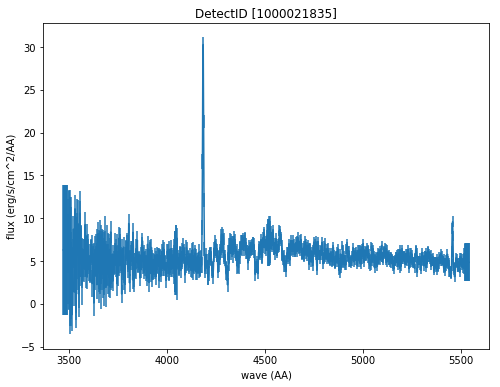

In [14]:
source = detect_table['detectid'][3]
spectra_table = spectra.read_where("detectid == source")
plot_spectrum(spectra_table)

To constrain x-axis of the plot to the line emission:

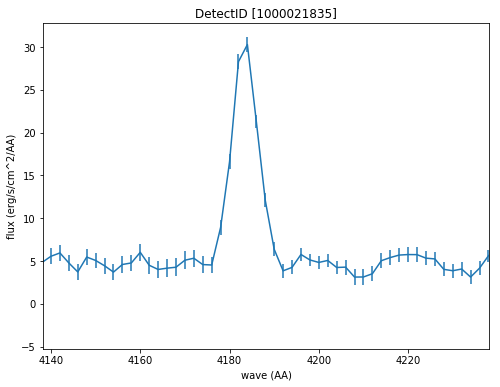

In [15]:
cw = detect_table['wave'][0]
plot_spectrum(spectra_table, xlim=[cw-50,cw+50])

You can find a list of all fibers used in the measurement in the Fibers table. The Fibers table and its associated columns can be accessed similar to the Spectra table by searching for a match in the the detectid column. 

In [16]:
fibers = fileh.root.Fibers
fibers.cols

/Fibers.cols (Cols), 20 columns
  detectid (Column(9397618,), int64)
  ra (Column(9397618,), float32)
  dec (Column(9397618,), float32)
  multiframe (Column(9397618,), |S20)
  fibnum (Column(9397618,), int32)
  x_ifu (Column(9397618,), float32)
  y_ifu (Column(9397618,), float32)
  date (Column(9397618,), int32)
  obsid (Column(9397618,), int32)
  expnum (Column(9397618,), int32)
  distance (Column(9397618,), float32)
  timestamp (Column(9397618,), |S17)
  wavein (Column(9397618,), float32)
  flag (Column(9397618,), int32)
  weight (Column(9397618,), float32)
  ADC (Column(9397618, 5), ('<f4', (5,)))
  amp (Column(9397618,), |S2)
  ifuid (Column(9397618,), |S3)
  ifuslot (Column(9397618,), |S3)
  specid (Column(9397618,), |S3)

Access the fiber table for the above source:

In [17]:
fiber_table = fibers.read_where("detectid == source") 

In [18]:
fiber_table

array([(1000021835, 150.07697, 2.3093488, 'multi_016_104_026_LL',  69, 24.15,  -8.81, 20170222, 8, 1, 2.3212  , '20170222T052514.0', 4183.45, 0,  18.63, [1.289, 1.119, 1.   , 0.984, 0.925], 'LL', '026', '104', '016'),
       (1000021835, 150.07658, 2.3099465, 'multi_016_104_026_LL',  70, 21.61,  -8.81, 20170222, 8, 1, 1.92159 , '20170222T052514.0', 4183.45, 0,  40.17, [0.639, 0.825, 1.   , 1.008, 1.042], 'LL', '026', '104', '016'),
       (1000021835, 150.07729, 2.309974 , 'multi_016_104_026_LL',  89, 22.88, -11.02, 20170222, 8, 1, 0.628049, '20170222T052514.0', 4183.45, 0, 292.2 , [1.206, 1.103, 1.   , 0.999, 0.989], 'LL', '026', '104', '016'),
       (1000021835, 150.07692, 2.3105717, 'multi_016_104_026_LL',  90, 20.34, -11.02, 20170222, 8, 1, 2.26937 , '20170222T052514.0', 4183.45, 0,  20.54, [0.506, 0.739, 1.   , 1.007, 1.057], 'LL', '026', '104', '016'),
       (1000021835, 150.07762, 2.3105977, 'multi_016_104_026_LL', 109, 21.61, -13.22, 20170222, 8, 1, 2.88789 , '20170222T052514

When you are done with the HDF5 file, close it. The data that you extracted into tables and arrays will remain.

In [19]:
fileh.close()

## Accessing the ELiXer Classifications

In [20]:
file_elix = tb.open_file(config.elixerh5)

In [21]:
file_elix.root.Classifications

/Classifications (Table(690868,)) ''
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "plae_poii_hetdex": Float32Col(shape=(), dflt=0.0, pos=1),
  "aperture_mag": Float32Col(shape=(), dflt=0.0, pos=2),
  "plae_poii_aperture": Float32Col(shape=(), dflt=0.0, pos=3),
  "aperture_filter": StringCol(itemsize=15, shape=(), dflt='', pos=4),
  "mag_match": Float32Col(shape=(), dflt=0.0, pos=5),
  "cat_filter": StringCol(itemsize=15, shape=(), dflt='', pos=6),
  "plae_poii_cat": Float32Col(shape=(), dflt=0.0, pos=7),
  "dec": Float32Col(shape=(), dflt=0.0, pos=8),
  "dec_match": Float32Col(shape=(), dflt=0.0, pos=9),
  "dist_match": Float32Col(shape=(), dflt=0.0, pos=10),
  "ra": Float32Col(shape=(), dflt=0.0, pos=11),
  "ra_match": Float32Col(shape=(), dflt=0.0, pos=12),
  "z_prelim": Float32Col(shape=(), dflt=0.0, pos=13)}
  byteorder := 'little'
  chunkshape := (799,)
  autoindex := True
  colindexes := {
    "detectid": Index(9, full, shuffle, zlib(1)).is_csi=True}